
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **TFM - Análisis de sentimiento pólitico en Twitter**
### <p style="text-align:center"> **1. EDA**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>
    

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 0. Data Reading and Problem statement
 1. <font color='darkgreen'>**EDA**</font>
 2. Word Cloud y Análisis de viralidad
 3. Best Model and Explainability

Este cuaderno tiene como objetivo realizar un Análisis Exploratorio de Datos para explorar y visualizar los datos. Se mostrarán diversas visualizaciones y se analizarán las correlaciones entre las variables. El objetivo es obtener una comprensión más profunda de los datos y descubrir patrones o relaciones significativas entre las variables. A través de gráficos y análisis estadísticos, se buscará revelar información clave que pueda ser útil para futuros análisis o toma de decisiones.

 INDICE:

 - [Importación de Librerias](#0) 
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Exploración de los datos](#3)


**Visualización**
 - [Número de Tweets por partido](#4.1)
 - [Número de post por sentimiento](#4.2)
 - [Promedio de comentarios por partido](#4.3)
 - [Promedio de Me gusta por partido](#4.4)
 - [Promedio de Visistas por partido](#4.5)
 - [Calidad de los tweets](#4.6)
 - [Temporalidad de los posts](#4.7)
 - [Longitud de los tweets](#4.8)
 - [Análisis de frecuencia de palabras](#4.9)
 - [Análisis de hashtags](#4.10)
 - [Análisis de menciones](#4.11)
 - [Partidos que Twitearon el 27 de Mayo (Jornada de Reflexión](#4.12)

 
 
 
 

 
 
 
 
 **Correlación**
 - [Correlación de las variables](#5)
 - [Spearman](#5.1)
 - [Cramer's V](#5.2)
 - [Pearson](#5.3)





##  <a name="0"> Importación de Librerias</a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re


import warnings
warnings.filterwarnings('ignore')

##  <a name="1">Funciones utilizadas en este notebook</a>

In [2]:
def obtener_porcentajes_por_partido(dataframe, partido):
    # Filtrar el DataFrame por el partido especificado
    subset = dataframe[dataframe['partido'] == partido]
    
    # Obtener el conteo de sentimientos
    conteo_sentimientos = subset['sentimiento'].value_counts().reset_index()
    conteo_sentimientos.columns = ['sentimiento', 'conteo']
    
    # Calcular los porcentajes totales
    total = conteo_sentimientos['conteo'].sum()
    conteo_sentimientos['porcentaje'] = conteo_sentimientos['conteo'] / total * 100
    
    return conteo_sentimientos

In [3]:
def plot_sentimientos_por_partido(dataframe, partido):
    # Definir los colores para cada sentimiento
    colors = {'Positivo': 'green', 'Negativo': 'red', 'Neutral': '#CC7722'}
    
    # Filtrar el DataFrame por el partido especificado
    subset = dataframe[dataframe['partido'] == partido]
    
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.countplot(x='sentimiento', data=subset, palette=colors.values())
    plt.title(f'Conteo de Sentimientos para {partido}')
    plt.xlabel('Sentimiento')
    plt.ylabel('Conteo')
    plt.show()

In [4]:
def get_corr_matrix(dataset=None, metodo='spearman', size_figure=[10,8]):
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    corr = dataset.corr(method=metodo)
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    f, ax = plt.subplots(figsize=size_figure)
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()



In [5]:
def cramers_v(var1,var2):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

In [6]:
def plot_top_words(df, partido):
    """
    Función para plotear las 10 palabras más comunes para un partido especificado.

    Argumentos:
        df: DataFrame que contiene los datos.
        partido: El nombre del partido para el que se realizará la visualización.
    """
    
    # Importar las librerías necesarias
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from collections import Counter
    import matplotlib.pyplot as plt

    # Definir palabras vacías
    stop_words = set(stopwords.words('spanish'))

    # Filtrar el DataFrame para solo incluir posts del partido especificado
    df_party = df[df['partido'] == partido]

    # Función para extraer las 10 palabras más comunes de una serie de posts
    def top_words(posts):
        clean_words = [word.lower() for sublist in posts.apply(word_tokenize) for word in sublist if word.isalpha() and word not in stop_words]
        return Counter(clean_words).most_common(10)

    # Calcular las 10 palabras más comunes por partido
    top_words_by_party = top_words(df_party['post'])

    # Extraer las 10 palabras más comunes y sus frecuencias
    words, frequencies = zip(*top_words_by_party)
    
    # Imprimir las palabras
    print(f"\nTop 10 palabras más comunes para {partido}:")
    for word, freq in zip(words, frequencies):
        print(f"{word}: {freq}")
    
    # Crear una gráfica de barras horizontal
    plt.figure(figsize=(10,5))
    plt.barh(words, frequencies, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top 10 palabras más comunes para {partido}')
    plt.gca().invert_yaxis()
    plt.show()

In [7]:
def plot_top_hashtags(df, partido):
    """
    Función para plotear los 10 hashtags más comunes para un partido especificado.

    Argumentos:
        df: DataFrame que contiene los datos.
        partido: El nombre del partido para el que se realizará la visualización.
    """

    # Filtrar el DataFrame para solo incluir posts del partido especificado
    df_party = df[df['partido'] == partido]

    # Extraer hashtags
    hashtags_party = df_party['post'].apply(lambda x: re.findall(r"#(\w+)", x)).explode()

    # Calcular la frecuencia de hashtags
    hashtag_freq_party = hashtags_party.value_counts()

    # Extraer los 10 hashtags más comunes y sus frecuencias
    top_hashtags_party = hashtag_freq_party.head(10)

    # Comprobar si top_hashtags_party está vacío
    if not top_hashtags_party.empty:
        tags, freqs = zip(*top_hashtags_party.items())

        # Crear un gráfico de barras horizontal
        plt.figure(figsize=(10, 5))
        plt.barh(tags, freqs, color='skyblue')
        plt.xlabel('Frecuencia')
        plt.title(f'Top 10 hashtags más comunes para {partido}')
        plt.gca().invert_yaxis()
        plt.show()

        # Imprimir los 10 hashtags más comunes
        print(f"\nTop 10 hashtags más comunes para {partido}:")
        print(top_hashtags_party)
    else:
        print(f"No hay hashtags en los posts del partido '{partido}'")

In [8]:
def plot_top_mentions(df, partido):
    """
    Función para plotear las 10 menciones más comunes para un partido especificado.

    Argumentos:
        df: DataFrame que contiene los datos.
        partido: El nombre del partido para el que se realizará la visualización.
    """

    # Filtrar el DataFrame para solo incluir posts del partido especificado
    df_party = df[df['partido'] == partido]

    # Extraer menciones
    mentions_party = df_party['post'].apply(lambda x: re.findall(r"@(\w+)", x)).explode()

    # Calcular la frecuencia de menciones
    mention_freq_party = mentions_party.value_counts()

    # Extraer las 10 menciones más comunes y sus frecuencias
    top_mentions_party = mention_freq_party.head(10)

    # Comprobar si top_mentions_party está vacío
    if not top_mentions_party.empty:
        mentions, freqs = zip(*top_mentions_party.items())

        # Crear un gráfico de barras horizontal
        plt.figure(figsize=(10, 5))
        plt.barh(mentions, freqs, color='skyblue')
        plt.xlabel('Frecuencia')
        plt.title(f'Top 10 menciones más comunes para {partido}')
        plt.gca().invert_yaxis()
        plt.show()

        # Imprimir las 10 menciones más comunes
        print(f"\nTop 10 menciones más comunes para {partido}:")
        print(top_mentions_party)
    else:
        print(f"No hay menciones en los posts del partido '{partido}'")

##  <a name="2"> Carga de datos</a>

In [9]:
file_path = '../data/processed/df_sentimiento.csv'
df = pd.read_csv(file_path, usecols=['partido', 'candidato', 'nick', 'followers', 'fecha',
       'post', 'sentimiento', 'negative', 'neutral', 'positive', 'video',
       'foto', 'repost', 'retweet', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños'])

df.head()

,partido,candidato,nick,followers,fecha,post,sentimiento,negative,neutral,positive,...,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...",Positive,0.034475,0.037882,0.927643,...,58700.0,198.0,0.003373,261.0,0.004446,1260.0,0.021465,1586985.0,0.4734,71.0
1,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...",Negative,0.904359,0.060345,0.035295,...,101600.0,550.0,0.005413,561.0,0.005522,2127.0,0.020935,1586985.0,0.4734,70.0
2,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...",Positive,0.014554,0.021517,0.963929,...,59700.0,140.0,0.002345,213.0,0.003568,1042.0,0.017454,1586985.0,0.4734,70.0
3,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-13,❤️❤️,Positive,0.005584,0.010402,0.984014,...,159100.0,155.0,0.000974,343.0,0.002156,2958.0,0.018592,1586985.0,0.4734,70.0
4,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-13,Presidente: líbranos del mal.,Negative,0.680318,0.128941,0.190741,...,330800.0,893.0,0.002700,549.0,0.001660,2592.0,0.007836,1586985.0,0.4734,70.0


##  <a name="3"> Exploración de los datos</a>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partido             773 non-null    object 
 1   candidato           773 non-null    object 
 2   nick                773 non-null    object 
 3   followers           773 non-null    float64
 4   fecha               773 non-null    object 
 5   post                771 non-null    object 
 6   sentimiento         774 non-null    object 
 7   negative            774 non-null    float64
 8   neutral             774 non-null    float64
 9   positive            774 non-null    float64
 10  video               773 non-null    object 
 11  foto                773 non-null    object 
 12  repost              773 non-null    object 
 13  retweet             773 non-null    object 
 14  viewed              773 non-null    float64
 15  comments            773 non-null    float64
 16  comments

**Comprobamos Nulos**

In [11]:
df.isnull().sum()

partido               1
candidato             1
nick                  1
followers             1
fecha                 1
post                  3
sentimiento           0
negative              0
neutral               0
positive              0
video                 1
foto                  1
repost                1
retweet               1
viewed                1
comments              1
comments vs viewed    1
shared                1
shared vs viewed      1
likes                 1
likes vs viewed       1
votos                 1
porcentaje            1
escaños               1
dtype: int64

In [12]:
#Al cargar los datos crea una fila de nulos
df = df.drop(773)

# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Convertir las columnas 'video', 'repost', 'retweet' a booleanos
df['foto'] = df['foto'].astype(bool)
df['video'] = df['video'].astype(bool)
df['repost'] = df['repost'].astype(bool)
df['retweet'] = df['retweet'].astype(bool)

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   partido             773 non-null    object        
 1   candidato           773 non-null    object        
 2   nick                773 non-null    object        
 3   followers           773 non-null    float64       
 4   fecha               773 non-null    datetime64[ns]
 5   post                771 non-null    object        
 6   sentimiento         773 non-null    object        
 7   negative            773 non-null    float64       
 8   neutral             773 non-null    float64       
 9   positive            773 non-null    float64       
 10  video               773 non-null    bool          
 11  foto                773 non-null    bool          
 12  repost              773 non-null    bool          
 13  retweet             773 non-null    bool          

partido               0
candidato             0
nick                  0
followers             0
fecha                 0
post                  2
sentimiento           0
negative              0
neutral               0
positive              0
video                 0
foto                  0
repost                0
retweet               0
viewed                0
comments              0
comments vs viewed    0
shared                0
shared vs viewed      0
likes                 0
likes vs viewed       0
votos                 0
porcentaje            0
escaños               0
dtype: int64

En Ambos casos son fotos o repost de una foto por lo tanto eliminamos las filas

# **Visualización**

##  <a name="4.1">Número de Tweets por partido</a>

In [18]:
df['partido'].value_counts()

MÁS MADRID    223
VOX           202
PODEMOS       197
PSOE           95
PP             54
Name: partido, dtype: int64

Lo Gráficamos

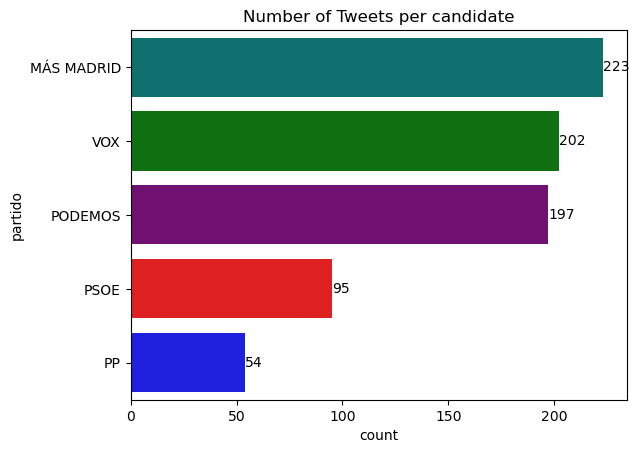

In [19]:
# Crear un diccionario de colores
color_dict = {'PSOE': 'Red', 'PP': 'blue', 'VOX': 'green', 'MÁS MADRID': 'teal', 'PODEMOS': 'purple'}

# Crear el gráfico de conteo
ax = sns.countplot(data = df, y = 'partido', order = df.partido.value_counts().index, palette = color_dict)

# Añadir las etiquetas a las barras
ax.bar_label(ax.containers[0])

# Configurar el título del gráfico
ax.set_title('Number of Tweets per candidate')

# Mostrar el gráfico
plt.show()


##  <a name="4.2">Número de post por sentimiento</a>

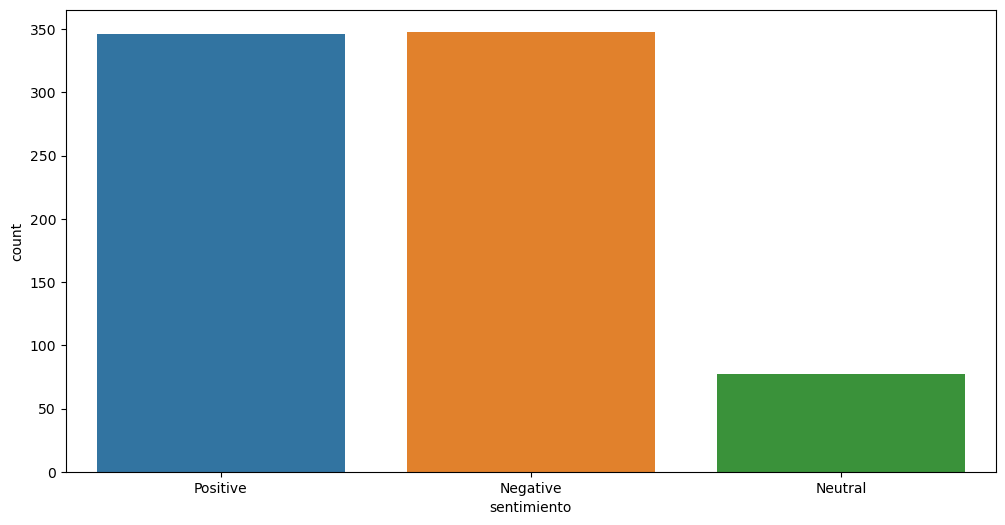

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentimiento', data=df)
plt.show()

## **Número de post por sentimiento por Partido**

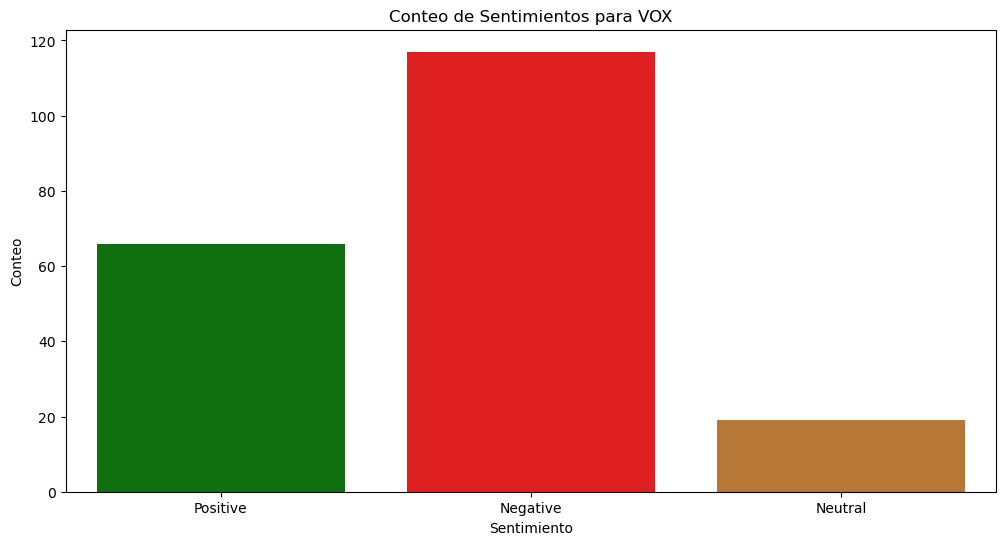

  sentimiento  conteo  porcentaje
0    Negative     117   57.920792
1    Positive      66   32.673267
2     Neutral      19    9.405941


In [21]:
plot_sentimientos_por_partido(df, 'VOX')
resultados = obtener_porcentajes_por_partido(df, 'VOX')
print(resultados)

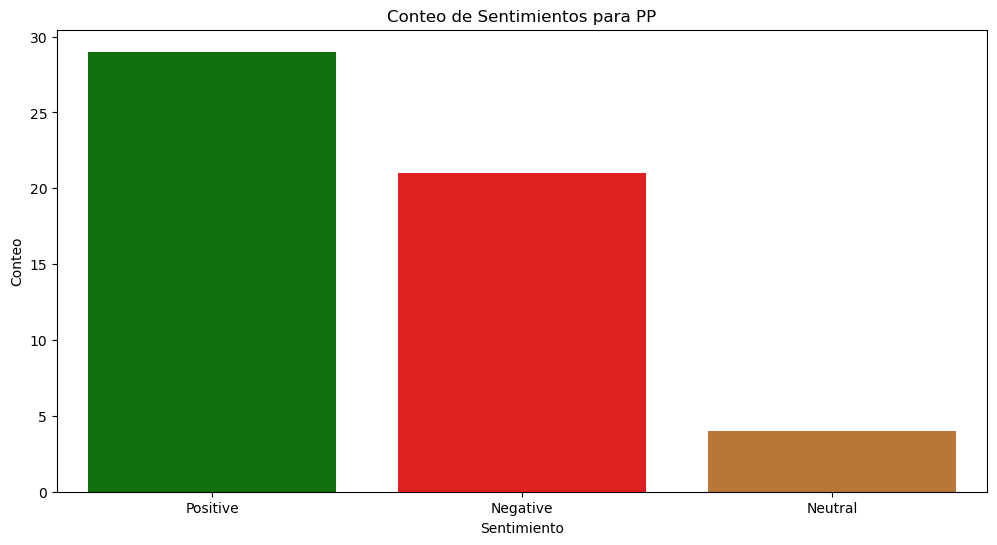

  sentimiento  conteo  porcentaje
0    Positive      29   53.703704
1    Negative      21   38.888889
2     Neutral       4    7.407407


In [22]:
plot_sentimientos_por_partido(df, 'PP')
resultados = obtener_porcentajes_por_partido(df, 'PP')
print(resultados)

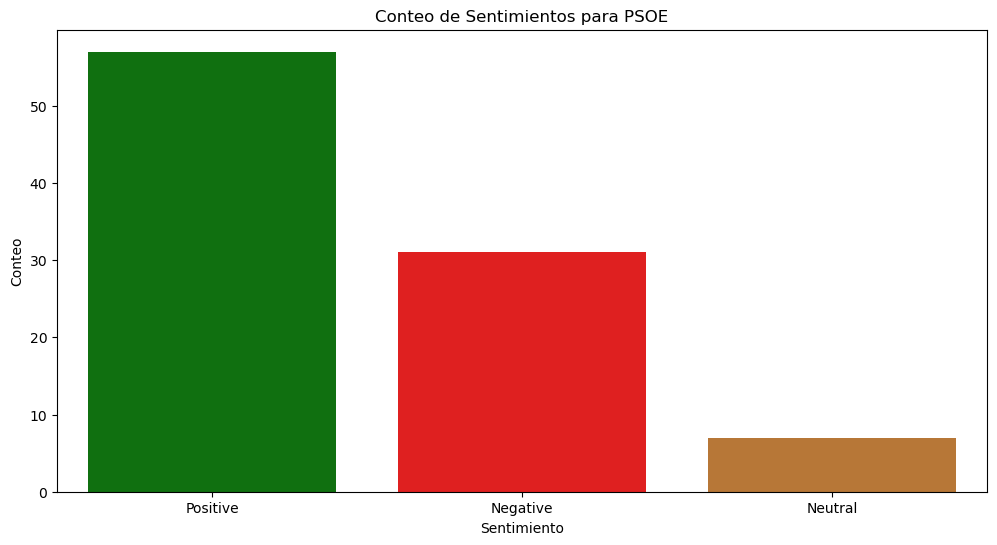

  sentimiento  conteo  porcentaje
0    Positive      57   60.000000
1    Negative      31   32.631579
2     Neutral       7    7.368421


In [23]:
plot_sentimientos_por_partido(df, 'PSOE')
resultados = obtener_porcentajes_por_partido(df, 'PSOE')
print(resultados)

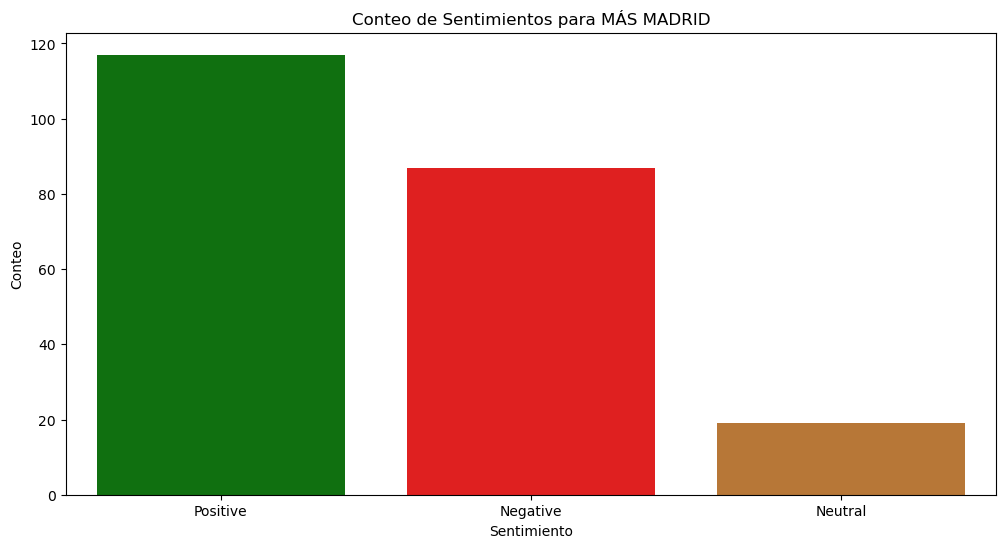

  sentimiento  conteo  porcentaje
0    Positive     117   52.466368
1    Negative      87   39.013453
2     Neutral      19    8.520179


In [24]:
plot_sentimientos_por_partido(df, 'MÁS MADRID')
resultados = obtener_porcentajes_por_partido(df, 'MÁS MADRID')
print(resultados)

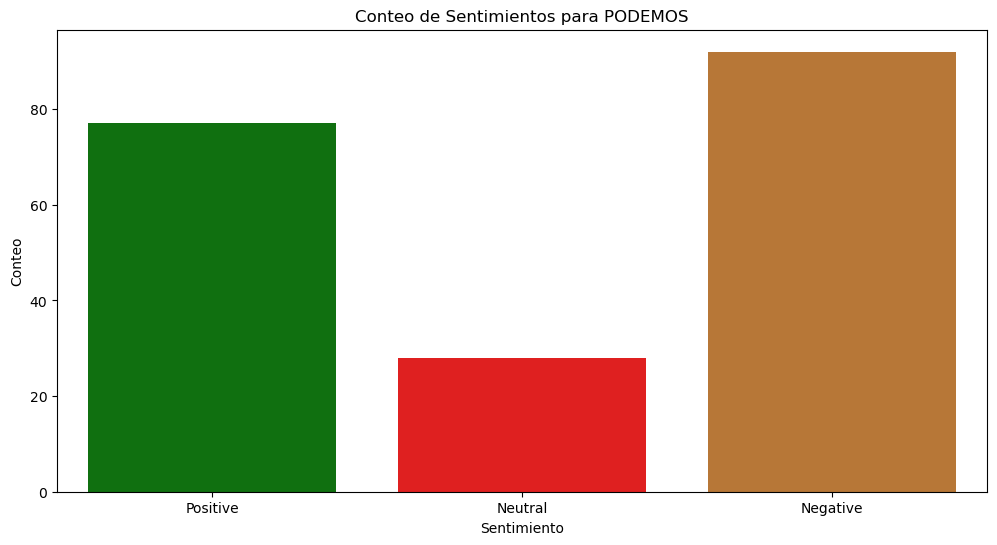

  sentimiento  conteo  porcentaje
0    Negative      92   46.700508
1    Positive      77   39.086294
2     Neutral      28   14.213198


In [25]:
plot_sentimientos_por_partido(df, 'PODEMOS')
resultados = obtener_porcentajes_por_partido(df, 'PODEMOS')
print(resultados)

## <a name="4.3"> Promedio de comentarios por partido</a>

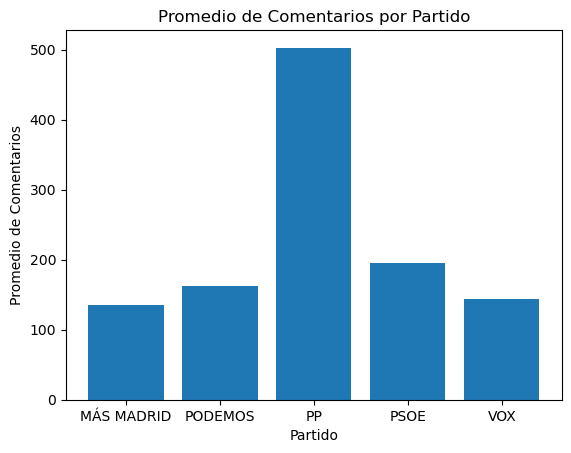

Promedio de comentarios por partido:
partido
MÁS MADRID    135.094170
PODEMOS       161.680203
PP            502.629630
PSOE          195.852632
VOX           144.252475
Name: comments, dtype: float64

Total de comentarios en todos los partidos:
136864.0


In [26]:
promedio_comentarios = df.groupby('partido')['comments'].mean()
total_comentarios = df['comments'].sum()

# Calcular el promedio de comentarios por partido
promedio_comentarios = df.groupby('partido')['comments'].mean()

# Crear el gráfico de barras para el promedio de comentarios por partido
plt.bar(promedio_comentarios.index, promedio_comentarios.values)
plt.xlabel('Partido')
plt.ylabel('Promedio de Comentarios')
plt.title('Promedio de Comentarios por Partido')

# Mostrar el gráfico
plt.show()

print("Promedio de comentarios por partido:")
print(promedio_comentarios)

print("\nTotal de comentarios en todos los partidos:")
print(total_comentarios)

 ## <a name="4.4"> Promedio de Me gusta por partido</a>

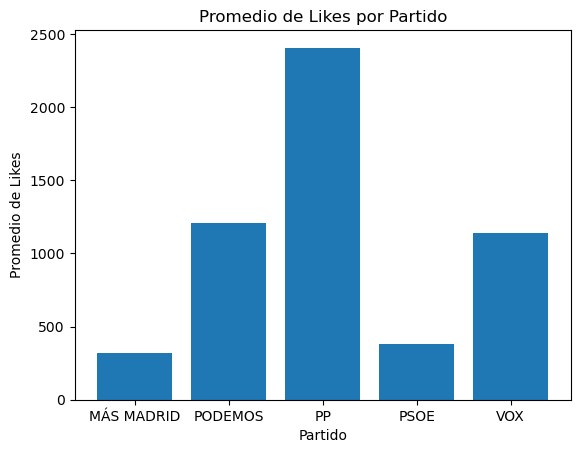

Promedio de likes por partido:
partido
MÁS MADRID     318.309417
PODEMOS       1211.248731
PP            2405.888889
PSOE           378.831579
VOX           1136.272277
Name: likes, dtype: float64

Total de likes en todos los partidos:
705033.0


In [27]:
promedio_likes = df.groupby('partido')['likes'].mean()
total_likes = df['likes'].sum()

# Calcular el promedio de likes por partido
promedio_likes = df.groupby('partido')['likes'].mean()

# Crear el gráfico de barras para el promedio de likes por partido
plt.bar(promedio_likes.index, promedio_likes.values)
plt.xlabel('Partido')
plt.ylabel('Promedio de Likes')
plt.title('Promedio de Likes por Partido')

# Mostrar el gráfico
plt.show()

print("Promedio de likes por partido:")
print(promedio_likes)

print("\nTotal de likes en todos los partidos:")
print(total_likes)

 ## <a name="4.5"> Promedio de Visistas por partido</a>

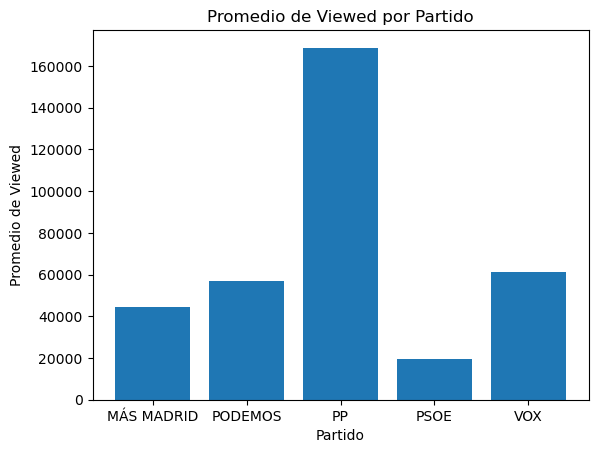

Promedio de viewed por partido:
partido
MÁS MADRID     44518.919283
PODEMOS        56716.218274
PP            168712.962963
PSOE           19625.926316
VOX            61161.237624
Name: viewed, dtype: float64


In [28]:
# Calcular el promedio de viewed por partido
promedio_viewed = df.groupby('partido')['viewed'].mean()

# Crear el gráfico de barras para el promedio de viewed por partido
plt.bar(promedio_viewed.index, promedio_viewed.values)
plt.xlabel('Partido')
plt.ylabel('Promedio de Viewed')
plt.title('Promedio de Viewed por Partido')

# Mostrar el gráfico
plt.show()

# Imprimir el promedio de viewed por partido
print("Promedio de viewed por partido:")
print(promedio_viewed)

## <a name="4.6"> Calidad de los tweets</a>

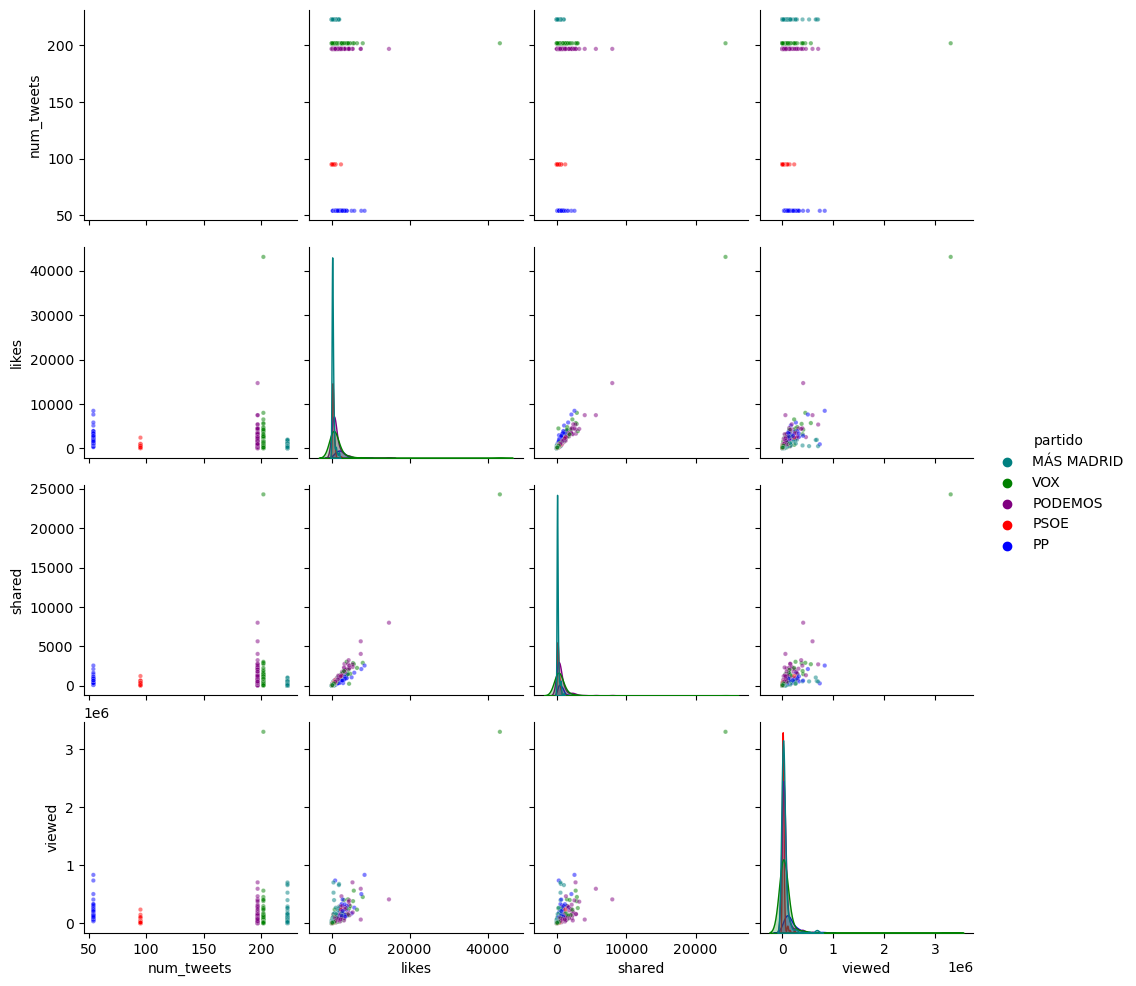

In [29]:
# Tomamos una muestra de los datos
df_sample = df.sample(frac=1, random_state=1)

# Creamos el nuevo DataFrame para el gráfico
df_sample['num_tweets'] = df_sample.groupby('partido')['post'].transform('count')

df_grafico = df_sample[['num_tweets', 'likes', 'shared', 'viewed', 'partido']]

color_dict = {'PSOE': 'Red', 'PP': 'blue', 'VOX': 'green', 'MÁS MADRID': 'teal', 'PODEMOS': 'purple'}

# Ajustamos el tamaño y la transparencia de los puntos
sns.pairplot(df_grafico, hue='partido', palette=color_dict, plot_kws={"s": 10, "alpha": 0.5})

plt.show()

## <a name="4.7"> Temporalidad de los posts</a>

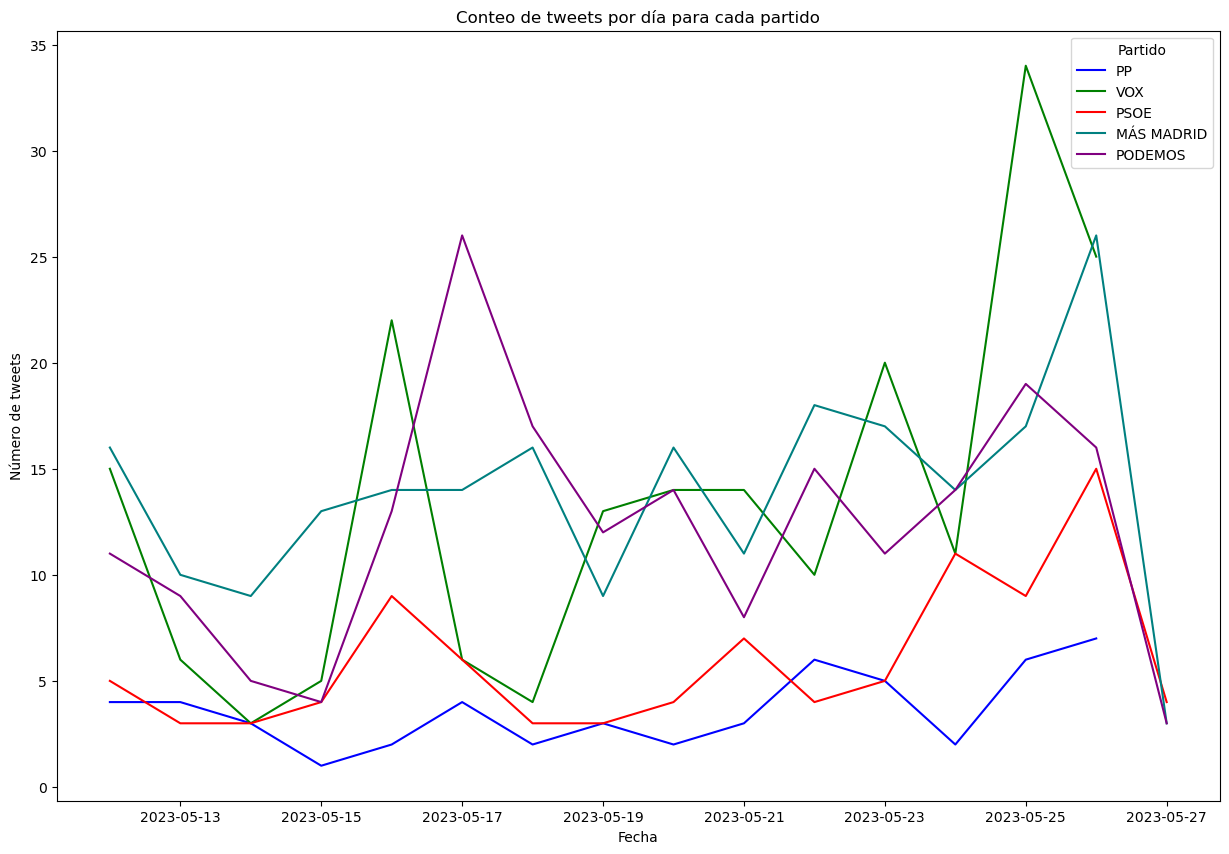

In [30]:
# Convertir la columna FECHA a un formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])

plt.figure(figsize=(15,10))

# Listar los partidos
partidos = df['partido'].unique()

# Definir el diccionario de colores
color_dict = {'PSOE': 'Red', 'PP': 'blue', 'VOX': 'green', 'MÁS MADRID': 'teal', 'PODEMOS': 'purple'}

# Asegurarte de que todos los partidos tengan asignado un color
for partido in partidos:
    if partido not in color_dict:
        color_dict[partido] = 'black' # Cambiar 'black' por cualquier otro color predeterminado

# Hacer un gráfico de línea para cada partido
for partido in partidos:
    df_partido = df[df['partido'] == partido]
    tweets_per_day = df_partido['fecha'].value_counts().sort_index()
    sns.lineplot(x=tweets_per_day.index, y=tweets_per_day.values, label=partido, color=color_dict[partido])

plt.title("Conteo de tweets por día para cada partido")
plt.xlabel("Fecha")
plt.ylabel("Número de tweets")
plt.legend(title='Partido')
plt.show()


## <a name="4.8"> Longitud de los tweets</a>

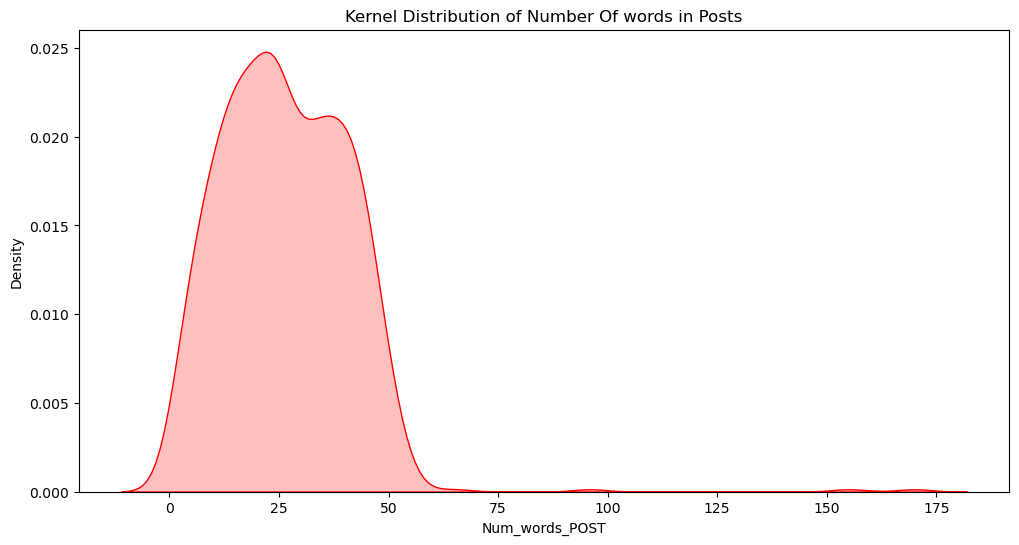

In [31]:
# Crear columnas para el número de palabras en 'POST'
df['Num_words_POST'] = df['post'].apply(lambda x : len(str(x).split()))

# Crear la figura y los ejes para el gráfico
plt.figure(figsize=(12,6))

# Crear el gráfico de densidad del kernel para cada columna
p1 = sns.kdeplot(df['Num_words_POST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words in Posts')

plt.show()


## **Longitud de los Tweets por Partido**

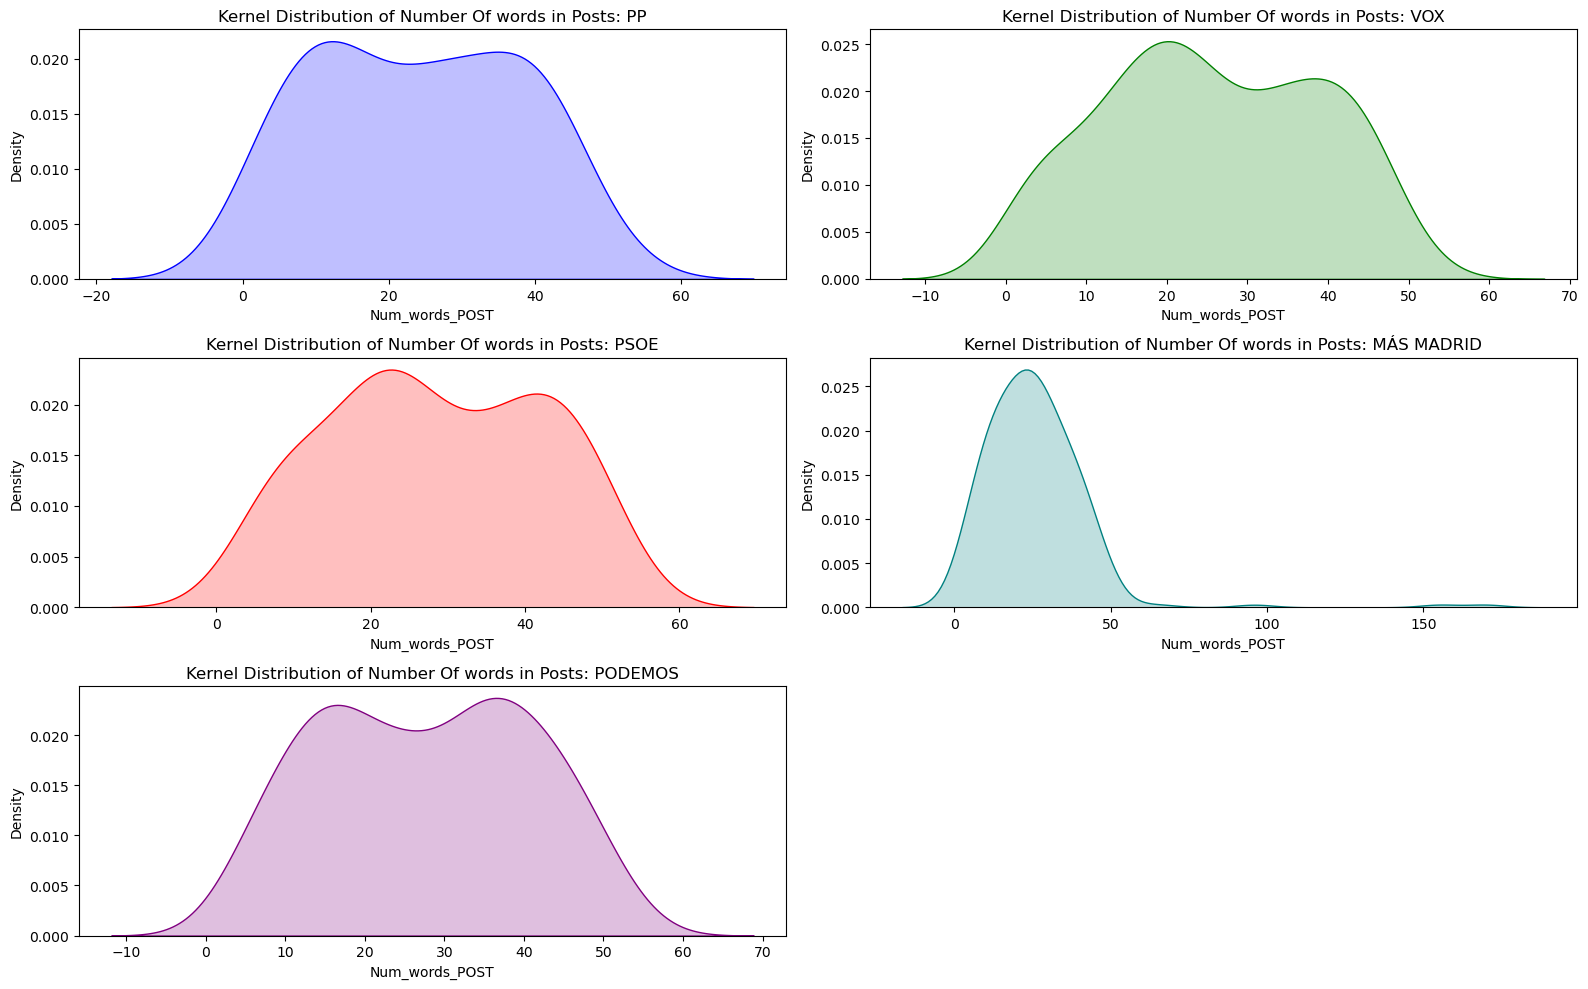

In [32]:
# Crear columnas para el número de palabras en 'POST'
df['Num_words_POST'] = df['post'].apply(lambda x : len(str(x).split()))

partidos = df['partido'].unique()

# Crear un diccionario de colores
color_dict = {'PSOE': 'Red', 'PP': 'blue', 'VOX': 'green', 'MÁS MADRID': 'teal', 'PODEMOS': 'purple'}

# Crear una figura
fig = plt.figure(figsize=(16,10))

for idx, partido in enumerate(partidos, start=1):
    ax = fig.add_subplot(3, 2, idx)  # 3 rows, 2 columns, index
    subset = df[df['partido'] == partido]
    sns.kdeplot(subset['Num_words_POST'], shade=True, color=color_dict[partido], ax=ax)
    ax.set_title(f'Kernel Distribution of Number Of words in Posts: {partido}')

plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()



# **Gráficas superpuesta de la longitud de los Tweets por Partido**

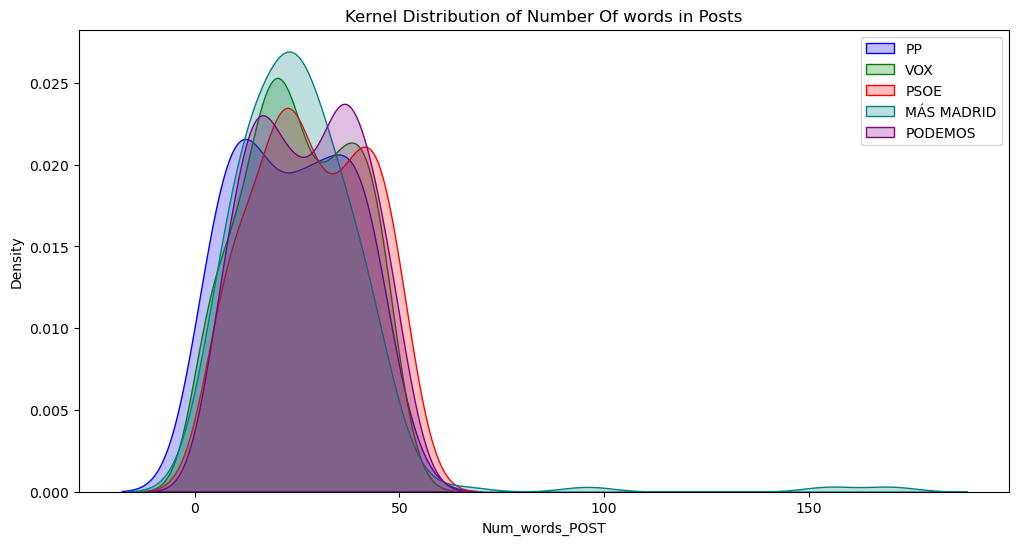

In [33]:
# Crear columnas para el número de palabras en 'POST'
df['Num_words_POST'] = df['post'].apply(lambda x : len(str(x).split()))

partidos = df['partido'].unique()

# Crear un diccionario de colores
color_dict = {'PSOE': 'Red', 'PP': 'blue', 'VOX': 'green', 'MÁS MADRID': 'teal', 'PODEMOS': 'purple'}

plt.figure(figsize=(12,6))

for partido in partidos:
    subset = df[df['partido'] == partido]
    sns.kdeplot(subset['Num_words_POST'], shade=True, color=color_dict[partido]).set_title('Kernel Distribution of Number Of words in Posts')

plt.legend(partidos)
plt.show()


## <a name="4.9"> Análisis de frecuencia de palabras</a>

Top 10 palabras más comunes:
madrid: 319
ayuso: 100
el: 91
monasterior: 65
comunidad: 64
votaseguro: 64
vamos: 59
la: 58
no: 57
en: 56


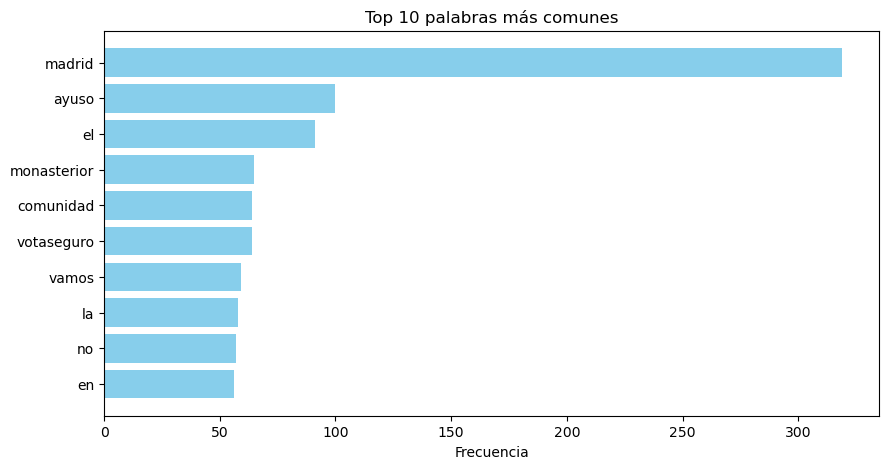

In [34]:
# Definir palabras vacías
stop_words = set(stopwords.words('spanish'))

# Tokenizar y limpiar palabras de los tweets
clean_words = [word.lower() for sublist in df['post'].apply(word_tokenize) for word in sublist if word.isalpha() and word not in stop_words]

# Calcular y obtener las 10 palabras más comunes
top_words = Counter(clean_words).most_common(10)

# Separar las palabras y sus frecuencias en dos listas
words, frequencies = zip(*top_words)

# Imprimir las palabras
print("Top 10 palabras más comunes:")
for word, freq in zip(words, frequencies):
    print(f"{word}: {freq}")

# Crear una gráfica de barras horizontal
plt.figure(figsize=(10,5))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Top 10 palabras más comunes')
plt.gca().invert_yaxis()
plt.show()


## Por Partido:


Top 10 palabras más comunes para MÁS MADRID:
madrid: 130
ayuso: 39
próximo: 38
vamos: 33
más: 26
sanidad: 25
en: 23
mejor: 23
lo: 21
el: 21


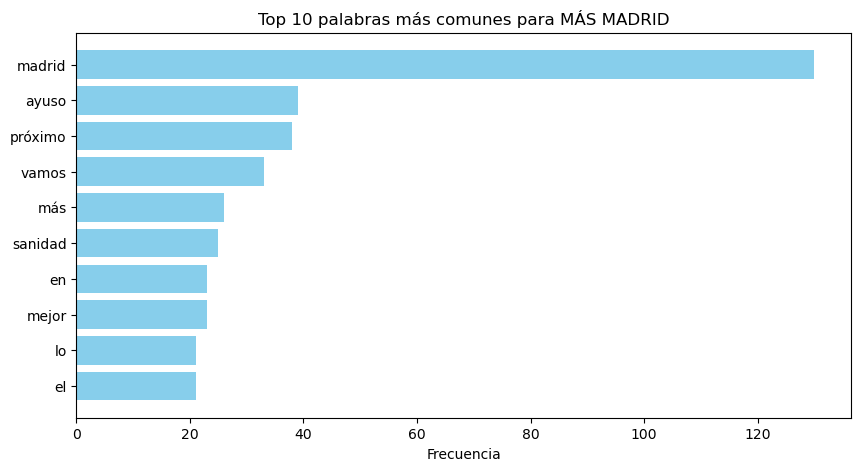


Top 10 palabras más comunes para VOX:
monasterior: 65
votaseguro: 64
vox: 52
madrid: 37
cuidalotuyo: 26
monasterio: 24
mayo: 23
rocío: 23
madrileños: 18
no: 18


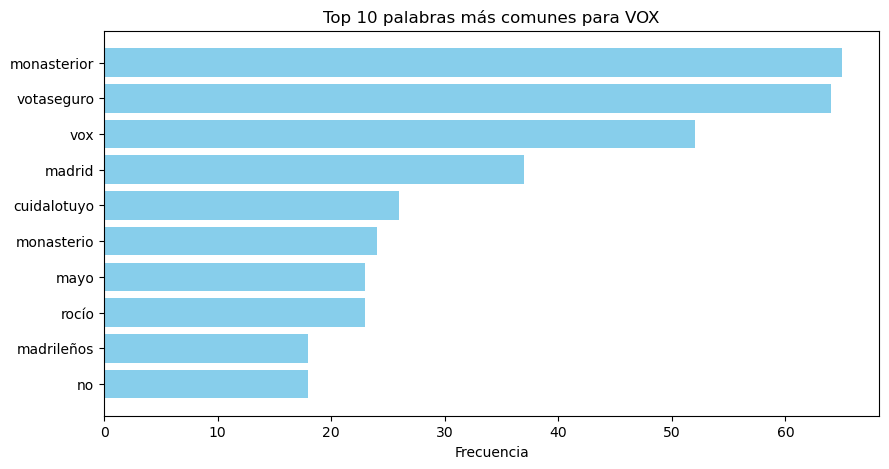


Top 10 palabras más comunes para PODEMOS:
madrid: 75
ayuso: 39
el: 30
comunidad: 29
vivienda: 26
alejacintourang: 25
la: 21
si: 21
vamos: 17
personas: 15


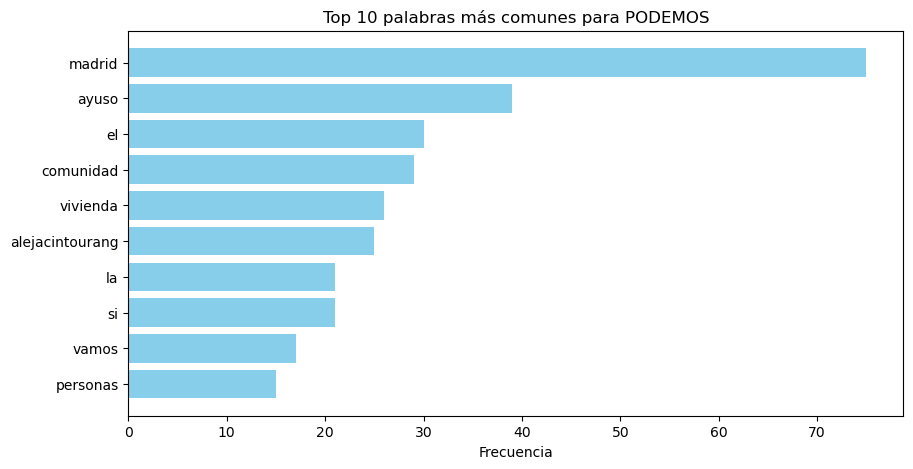


Top 10 palabras más comunes para PSOE:
madrid: 56
madriddaparatodos: 20
ayuso: 15
votapsoe: 14
el: 13
madrileños: 12
educación: 11
y: 11
jóvenes: 10
mi: 10


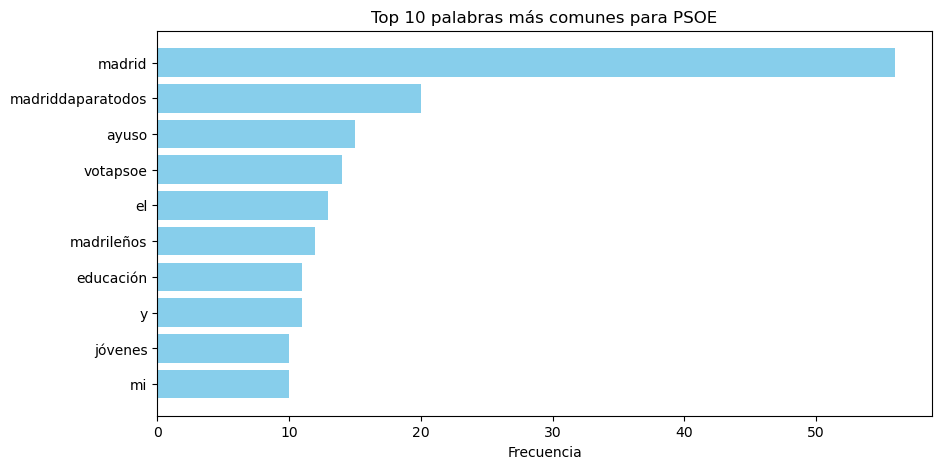


Top 10 palabras más comunes para PP:
madrid: 21
el: 11
con: 10
ganas: 10
vida: 7
la: 7
libertad: 6
españa: 6
pido: 5
no: 5


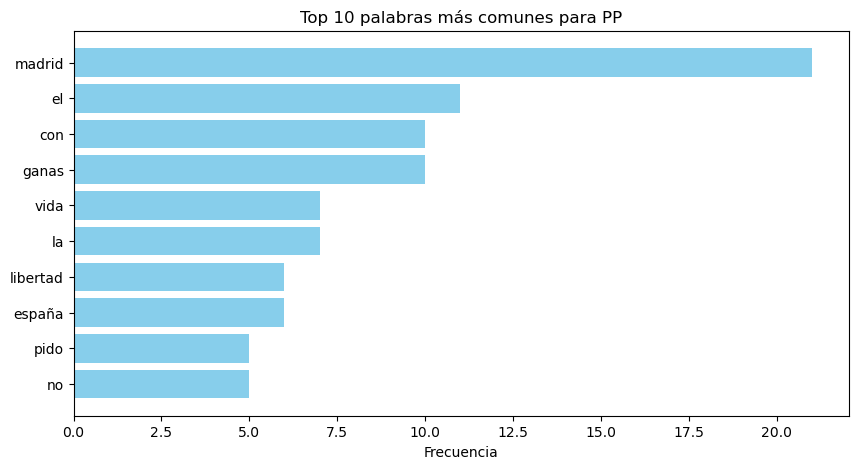

In [35]:
partidos = ['MÁS MADRID', 'VOX', 'PODEMOS', 'PSOE', 'PP']

for partido in partidos:
    plot_top_words(df, partido)

## <a name="4.10"> Análisis de hashtags</a>

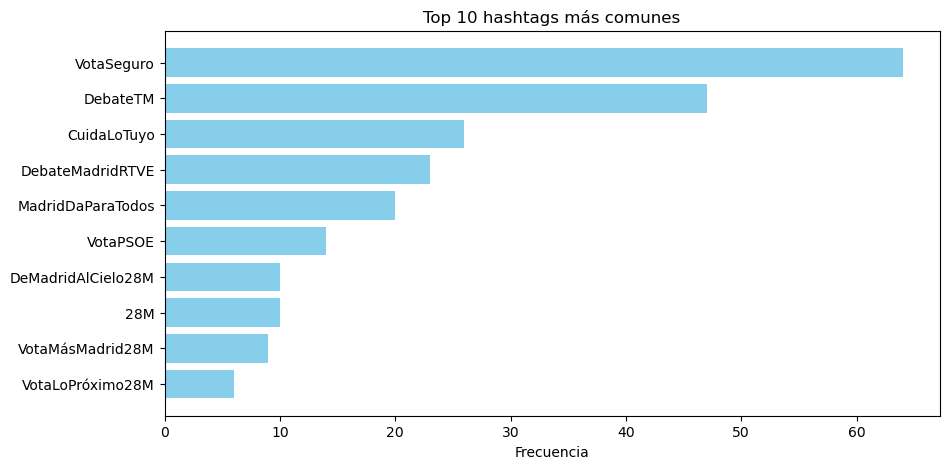

VotaSeguro            64
DebateTM              47
CuidaLoTuyo           26
DebateMadridRTVE      23
MadridDaParaTodos     20
VotaPSOE              14
DeMadridAlCielo28M    10
28M                   10
VotaMásMadrid28M       9
VotaLoPróximo28M       6
Name: post, dtype: int64


In [36]:
# Extraer hashtags
hashtags = df['post'].apply(lambda x: re.findall(r"#(\w+)", x)).explode()

# Calcular la frecuencia de hashtags
hashtag_freq = hashtags.value_counts()

# Extraer los 10 hashtags más comunes y sus frecuencias
top_hashtags = hashtag_freq.head(10)
tags, freqs = zip(*top_hashtags.items())

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(tags, freqs, color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Top 10 hashtags más comunes')
plt.gca().invert_yaxis()
plt.show()

# Imprimir los 10 hashtags más comunes
print(hashtag_freq.head(10))


## Por Partido:

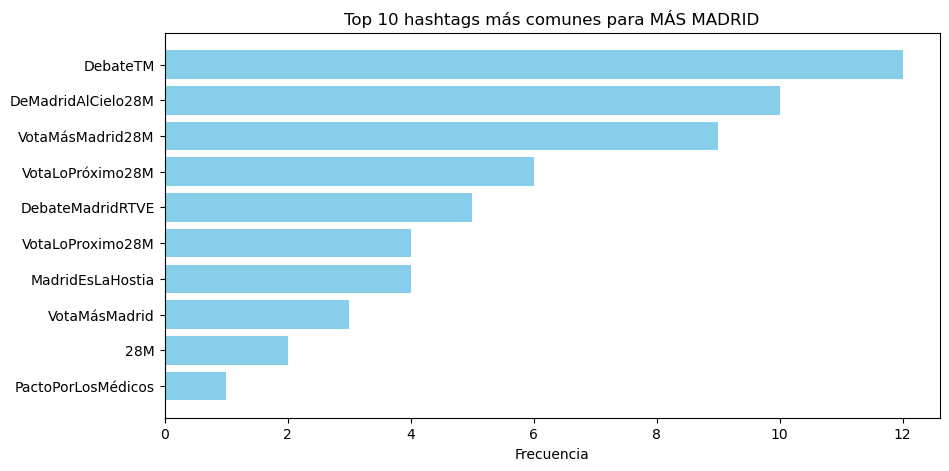


Top 10 hashtags más comunes para MÁS MADRID:
DebateTM              12
DeMadridAlCielo28M    10
VotaMásMadrid28M       9
VotaLoPróximo28M       6
DebateMadridRTVE       5
VotaLoProximo28M       4
MadridEsLaHostia       4
VotaMásMadrid          3
28M                    2
PactoPorLosMédicos     1
Name: post, dtype: int64


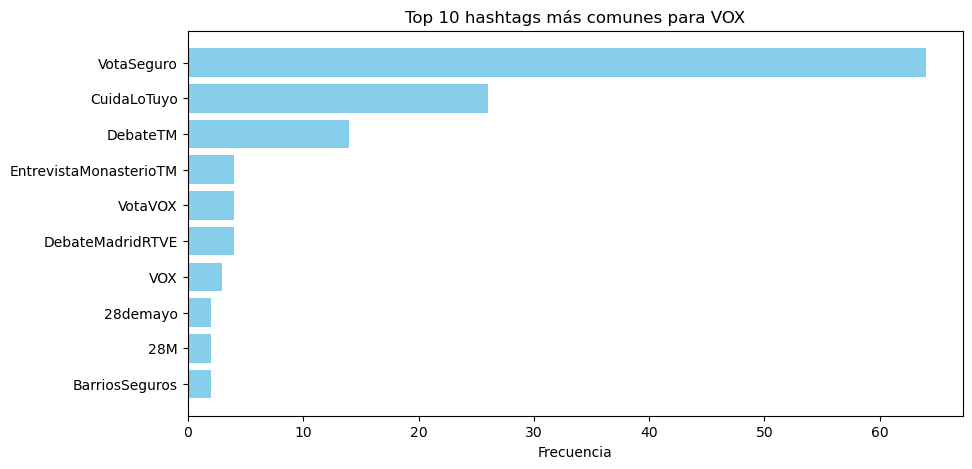


Top 10 hashtags más comunes para VOX:
VotaSeguro                64
CuidaLoTuyo               26
DebateTM                  14
EntrevistaMonasterioTM     4
VotaVOX                    4
DebateMadridRTVE           4
VOX                        3
28demayo                   2
28M                        2
BarriosSeguros             2
Name: post, dtype: int64


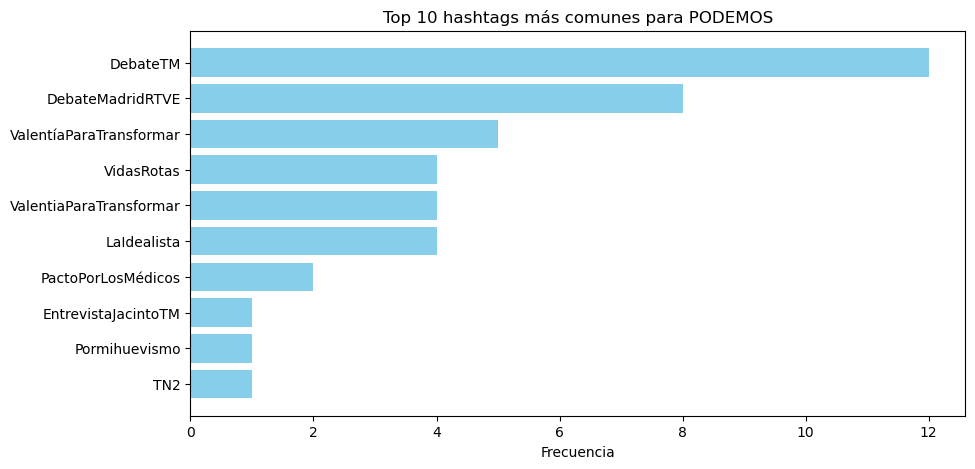


Top 10 hashtags más comunes para PODEMOS:
DebateTM                   12
DebateMadridRTVE            8
ValentíaParaTransformar     5
VidasRotas                  4
ValentiaParaTransformar     4
LaIdealista                 4
PactoPorLosMédicos          2
EntrevistaJacintoTM         1
Pormihuevismo               1
TN2                         1
Name: post, dtype: int64


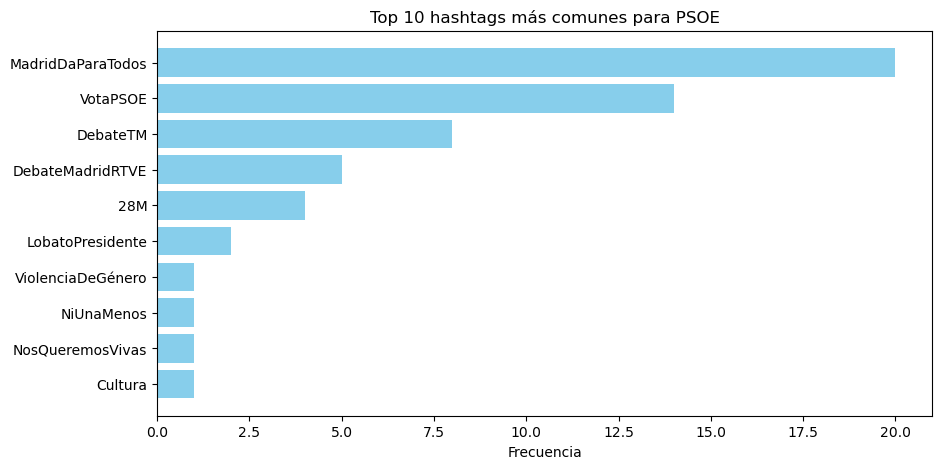


Top 10 hashtags más comunes para PSOE:
MadridDaParaTodos    20
VotaPSOE             14
DebateTM              8
DebateMadridRTVE      5
28M                   4
LobatoPresidente      2
ViolenciaDeGénero     1
NiUnaMenos            1
NosQueremosVivas      1
Cultura               1
Name: post, dtype: int64


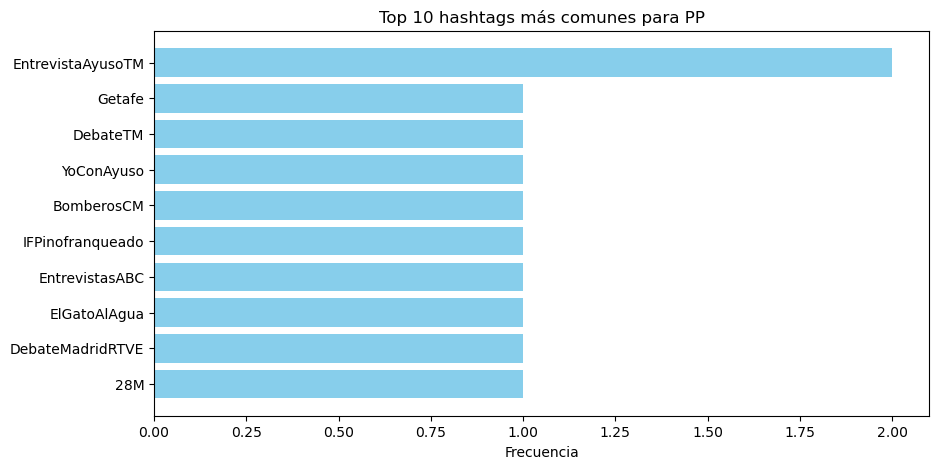


Top 10 hashtags más comunes para PP:
EntrevistaAyusoTM    2
Getafe               1
DebateTM             1
YoConAyuso           1
BomberosCM           1
IFPinofranqueado     1
EntrevistasABC       1
ElGatoAlAgua         1
DebateMadridRTVE     1
28M                  1
Name: post, dtype: int64


In [37]:
partidos = ['MÁS MADRID', 'VOX', 'PODEMOS', 'PSOE', 'PP']

for partido in partidos:
    plot_top_hashtags(df, partido)

## <a name="4.11"> Análisis de menciones</a>

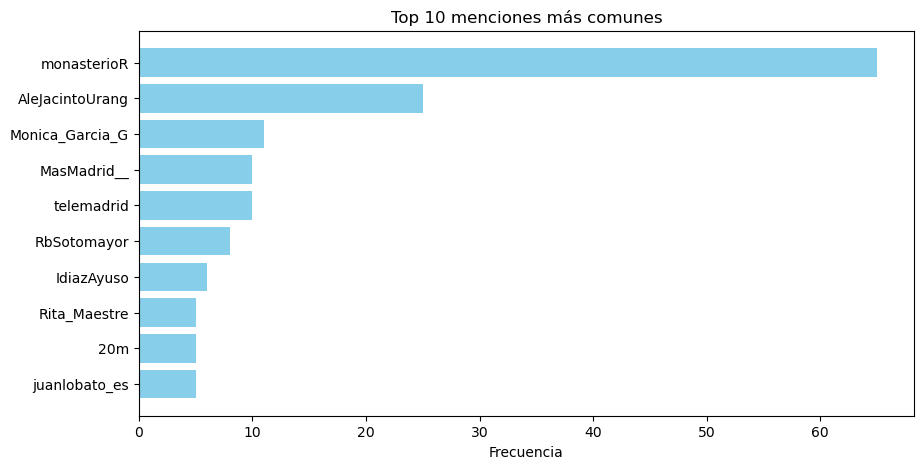

monasterioR        65
AleJacintoUrang    25
Monica_Garcia_G    11
MasMadrid__        10
telemadrid         10
RbSotomayor         8
IdiazAyuso          6
Rita_Maestre        5
20m                 5
juanlobato_es       5
Name: post, dtype: int64


In [38]:
# Extraer menciones
mentions = df['post'].apply(lambda x: re.findall(r"@(\w+)", x)).explode()

# Calcular la frecuencia de menciones
mention_freq = mentions.value_counts()

# Extraer las 10 menciones más comunes y sus frecuencias
top_mentions = mention_freq.head(10)
mentions, freqs = zip(*top_mentions.items())

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 5))
plt.barh(mentions, freqs, color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Top 10 menciones más comunes')
plt.gca().invert_yaxis()
plt.show()

# Imprimir las 10 menciones más comunes
print(mention_freq.head(10))

## Por Partido:

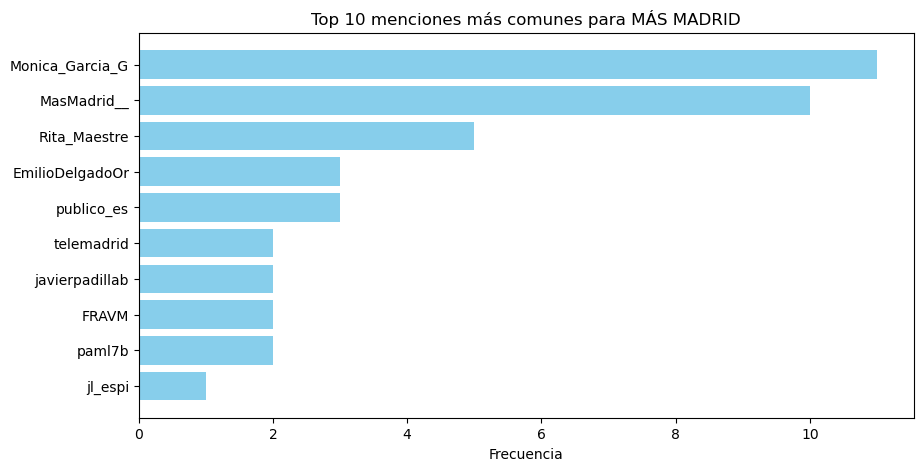


Top 10 menciones más comunes para MÁS MADRID:
Monica_Garcia_G    11
MasMadrid__        10
Rita_Maestre        5
EmilioDelgadoOr     3
publico_es          3
telemadrid          2
javierpadillab      2
FRAVM               2
paml7b              2
jl_espi             1
Name: post, dtype: int64


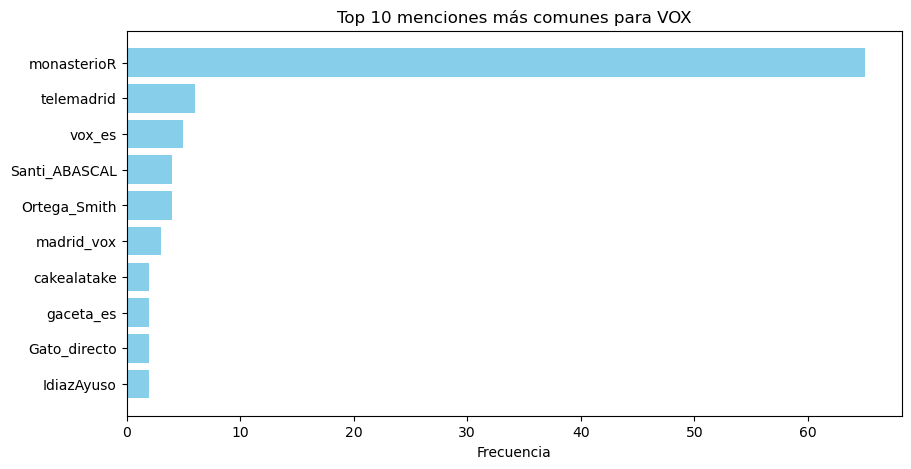


Top 10 menciones más comunes para VOX:
monasterioR      65
telemadrid        6
vox_es            5
Santi_ABASCAL     4
Ortega_Smith      4
madrid_vox        3
cakealatake       2
gaceta_es         2
Gato_directo      2
IdiazAyuso        2
Name: post, dtype: int64


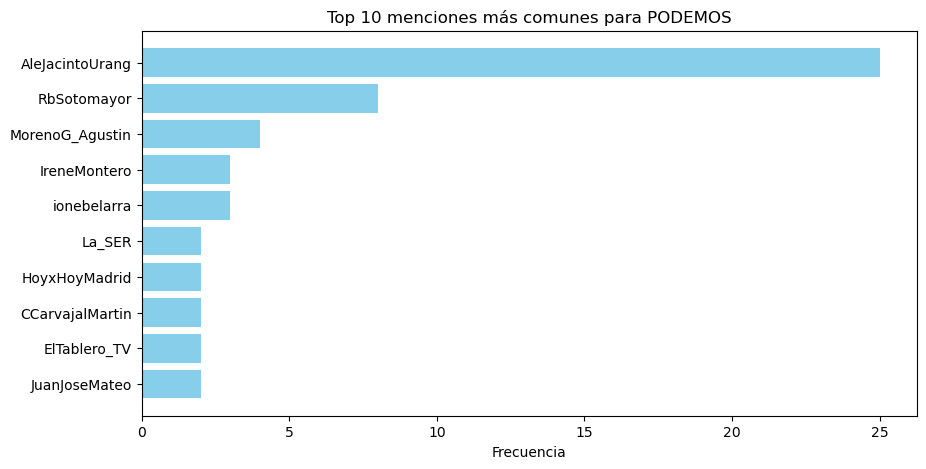


Top 10 menciones más comunes para PODEMOS:
AleJacintoUrang    25
RbSotomayor         8
MorenoG_Agustin     4
IreneMontero        3
ionebelarra         3
La_SER              2
HoyxHoyMadrid       2
CCarvajalMartin     2
ElTablero_TV        2
JuanJoseMateo       2
Name: post, dtype: int64


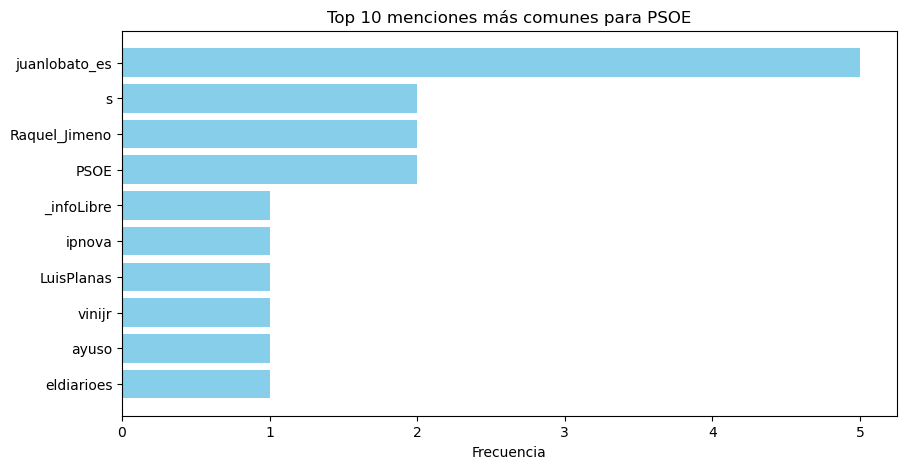


Top 10 menciones más comunes para PSOE:
juanlobato_es    5
s                2
Raquel_Jimeno    2
PSOE             2
_infoLibre       1
ipnova           1
LuisPlanas       1
vinijr           1
ayuso            1
eldiarioes       1
Name: post, dtype: int64


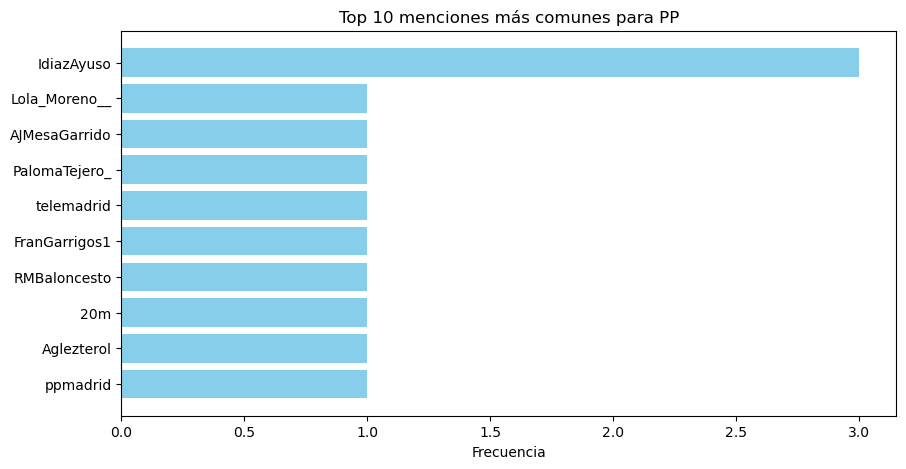


Top 10 menciones más comunes para PP:
IdiazAyuso       3
Lola_Moreno__    1
AJMesaGarrido    1
PalomaTejero_    1
telemadrid       1
FranGarrigos1    1
RMBaloncesto     1
20m              1
Aglezterol       1
ppmadrid         1
Name: post, dtype: int64


In [39]:
partidos = ['MÁS MADRID', 'VOX', 'PODEMOS', 'PSOE', 'PP']

for partido in partidos:
    plot_top_mentions(df, partido)

## <a name="4.12"> Partidos que Twitearon el 27 de Mayo (Jornada de Reflexión)</a>

In [40]:
# Filtrar el DataFrame
df_post_26_mayo = df[df['fecha'] > '2023-05-26']

# Obtener la lista única de partidos que han twitteado después del 26 de mayo de 2023
partidos_post_26_mayo = df_post_26_mayo['partido'].unique()

print("Los partidos que han twitteado después del 26 de mayo de 2023 son: ", partidos_post_26_mayo)


Los partidos que han twitteado después del 26 de mayo de 2023 son:  ['PSOE' 'MÁS MADRID' 'PODEMOS']


# **Correlación**

 ##  <a name="5"> Correlación de las variables</a> 

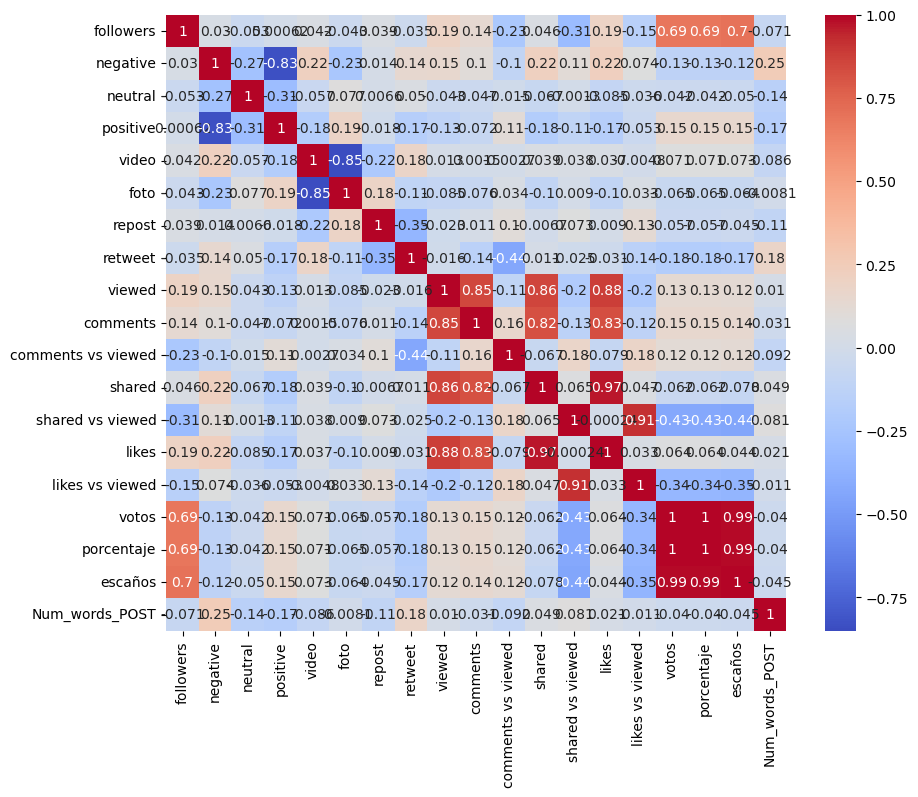

In [41]:
plt.figure(figsize=(10, 8))  # Tamaño personalizado en pulgadas (ancho, alto)
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

## <a name="5.1">Spearman</a> 

In [42]:
df_spearman = df[['partido', 'candidato', 'nick', 'followers', 'fecha',
       'post', 'sentimiento', 'negative', 'neutral', 'positive', 'video',
       'foto', 'repost', 'retweet', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]
df_spearman.head()

,partido,candidato,nick,followers,fecha,post,sentimiento,negative,neutral,positive,...,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...",Positive,0.034475,0.037882,0.927643,...,58700.0,198.0,0.003373,261.0,0.004446,1260.0,0.021465,1586985.0,0.4734,71.0
1,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...",Negative,0.904359,0.060345,0.035295,...,101600.0,550.0,0.005413,561.0,0.005522,2127.0,0.020935,1586985.0,0.4734,70.0
2,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...",Positive,0.014554,0.021517,0.963929,...,59700.0,140.0,0.002345,213.0,0.003568,1042.0,0.017454,1586985.0,0.4734,70.0
3,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-13,❤️❤️,Positive,0.005584,0.010402,0.984014,...,159100.0,155.0,0.000974,343.0,0.002156,2958.0,0.018592,1586985.0,0.4734,70.0
4,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100.0,2023-05-13,Presidente: líbranos del mal.,Negative,0.680318,0.128941,0.190741,...,330800.0,893.0,0.002700,549.0,0.001660,2592.0,0.007836,1586985.0,0.4734,70.0


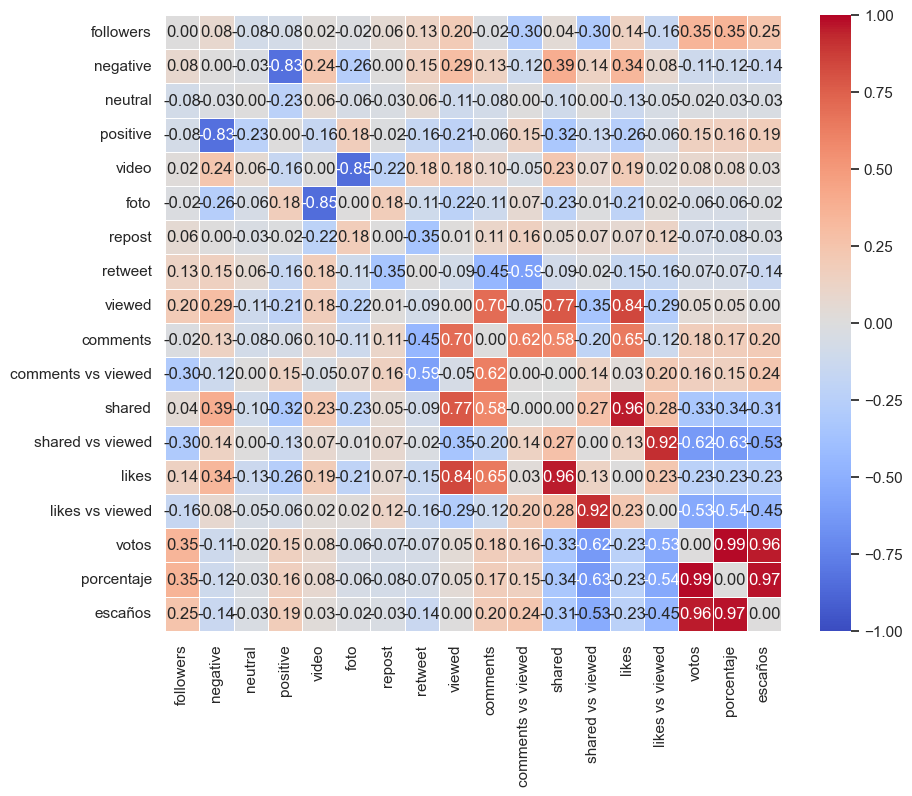

In [43]:
get_corr_matrix(dataset = df_spearman, size_figure = [10,8])

In [44]:
spearman = df_spearman.corr(method = 'spearman')
print(spearman)

                    followers  negative   neutral  positive     video  \
followers            1.000000  0.081442 -0.079308 -0.077481  0.021063   
negative             0.081442  1.000000 -0.028680 -0.834902  0.236624   
neutral             -0.079308 -0.028680  1.000000 -0.228043  0.056279   
positive            -0.077481 -0.834902 -0.228043  1.000000 -0.163222   
video                0.021063  0.236624  0.056279 -0.163222  1.000000   
foto                -0.018294 -0.258944 -0.061431  0.178678 -0.850272   
repost               0.057898  0.002639 -0.034020 -0.015601 -0.220686   
retweet              0.125638  0.152096  0.055406 -0.164627  0.180288   
viewed               0.200869  0.289961 -0.109424 -0.213157  0.176795   
comments            -0.016398  0.133215 -0.083996 -0.062112  0.097419   
comments vs viewed  -0.295089 -0.118337  0.003443  0.148029 -0.048210   
shared               0.040149  0.394621 -0.101364 -0.322366  0.228749   
shared vs viewed    -0.304482  0.140318  0.000180 -

## <a name="5.2">Cramer's V</a> 

First we define the categorical variables (excluding the target variable)

In [45]:
df_categorical_variables = df[['partido', 'candidato', 'nick', 'sentimiento', 'video',
                                               'foto', 'repost', 'retweet']]

df_categorical_variables.head()

,partido,candidato,nick,sentimiento,video,foto,repost,retweet
0,PP,Isabel Díaz Ayuso,@IdiazAyuso,Positive,True,False,False,False
1,PP,Isabel Díaz Ayuso,@IdiazAyuso,Negative,False,False,False,False
2,PP,Isabel Díaz Ayuso,@IdiazAyuso,Positive,False,True,False,False
3,PP,Isabel Díaz Ayuso,@IdiazAyuso,Positive,False,True,True,False
4,PP,Isabel Díaz Ayuso,@IdiazAyuso,Negative,False,True,False,False


<Axes: >

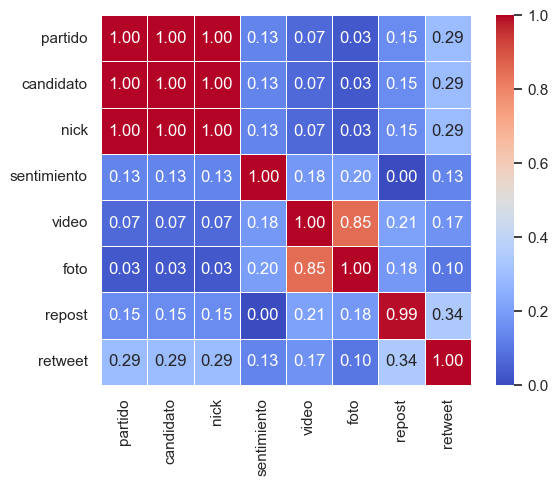

In [46]:
rows = []
for var1 in df_categorical_variables :
  col = []
  for var2 in df_categorical_variables :
    cramers = cramers_v(df_categorical_variables[var1], df_categorical_variables[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_vcramer = pd.DataFrame(cramers_results, columns = df_categorical_variables .columns,
                          index = df_categorical_variables .columns)

sns.heatmap(df_vcramer, vmin=0, vmax=1, square=True, annot=True, linewidths=.5, cmap='coolwarm', fmt=".2f")


In [47]:
df_vcramer

,partido,candidato,nick,sentimiento,video,foto,repost,retweet
partido,1.00,1.00,1.00,0.13,0.07,0.03,0.15,0.29
candidato,1.00,1.00,1.00,0.13,0.07,0.03,0.15,0.29
nick,1.00,1.00,1.00,0.13,0.07,0.03,0.15,0.29
sentimiento,0.13,0.13,0.13,1.00,0.18,0.20,0.00,0.13
video,0.07,0.07,0.07,0.18,1.00,0.85,0.21,0.17
foto,0.03,0.03,0.03,0.20,0.85,1.00,0.18,0.10
repost,0.15,0.15,0.15,0.00,0.21,0.18,0.99,0.34
retweet,0.29,0.29,0.29,0.13,0.17,0.10,0.34,1.00


##  <a name="5.3">Pearson</a>

In [48]:
df_continous_vairables = df[['followers', 'negative', 'neutral', 'positive', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]
df_continous_vairables.head()

,followers,negative,neutral,positive,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,912100.0,0.034475,0.037882,0.927643,58700.0,198.0,0.003373,261.0,0.004446,1260.0,0.021465,1586985.0,0.4734,71.0
1,912100.0,0.904359,0.060345,0.035295,101600.0,550.0,0.005413,561.0,0.005522,2127.0,0.020935,1586985.0,0.4734,70.0
2,912100.0,0.014554,0.021517,0.963929,59700.0,140.0,0.002345,213.0,0.003568,1042.0,0.017454,1586985.0,0.4734,70.0
3,912100.0,0.005584,0.010402,0.984014,159100.0,155.0,0.000974,343.0,0.002156,2958.0,0.018592,1586985.0,0.4734,70.0
4,912100.0,0.680318,0.128941,0.190741,330800.0,893.0,0.002700,549.0,0.001660,2592.0,0.007836,1586985.0,0.4734,70.0


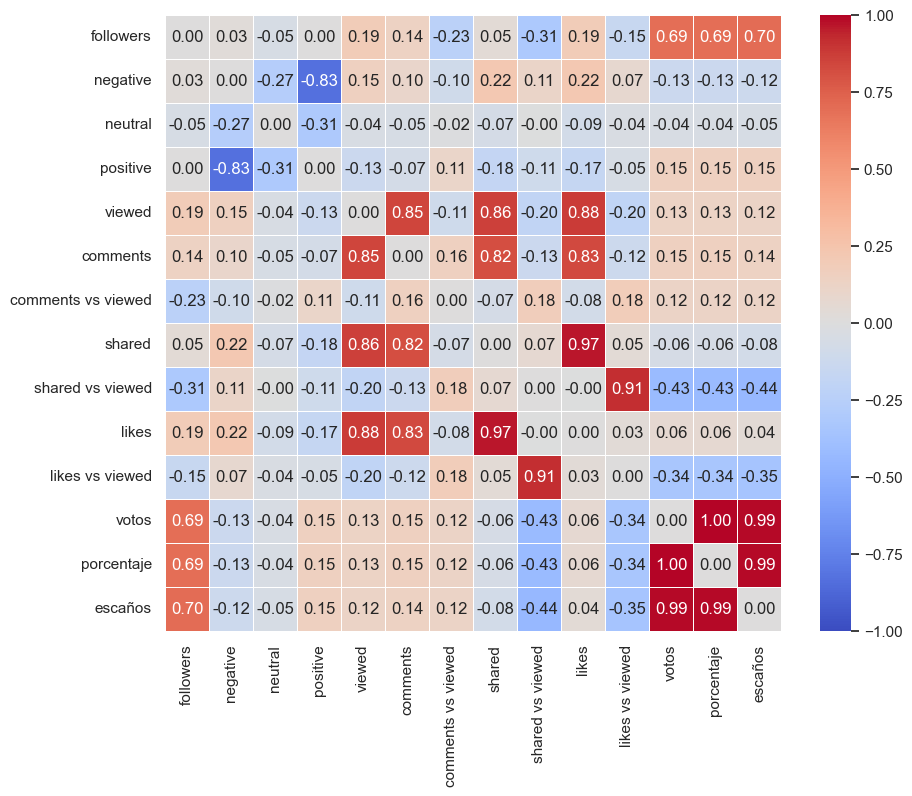

In [49]:
get_corr_matrix(dataset = df_continous_vairables,
                metodo = 'pearson', size_figure = [10,8])